In [32]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, Flatten
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
import tensorflow.keras.utils as ku 
import numpy as np 

from tensorflow.keras.callbacks import EarlyStopping

import re
import numpy as np
from nltk.corpus import stopwords
#from nltk.tokenize import word_tokenize
from razdel import tokenize 

import pymorphy2  

In [18]:
tokenizer = Tokenizer(num_words=1000)

data = open('bad_advices.txt', encoding='Utf-8').read()
#Читаем текст
corpus = data.lower().split("\n")

In [19]:
corpus[:10]

['григорий остер',
 '',
 '',
 'вредные советы',
 '',
 '',
 '',
 'книга для непослушных детей и их родителей',
 '',
 'послушным детям читать запрещается!']

In [20]:
stopword_ru = stopwords.words('russian')
len(stopword_ru)

morph = pymorphy2.MorphAnalyzer()

In [7]:
with open('stopwords.txt') as f:
    additional_stopwords = [w.strip() for w in f.readlines() if w]
stopword_ru += additional_stopwords
len(stopword_ru)

776

In [9]:
def clean_text(text):
    '''
    очистка текста
    на выходе очищеный текст
    
    '''
    if not isinstance(text, str):
        text = str(text)
    
    text = text.lower()
    text = text.strip('\n').strip('\r').strip('\t')
    text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text))

    text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
    text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)
    text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())
    
    #tokens = list(tokenize(text))
    #words = [_.text for _ in tokens]
    #words = [w for w in words if w not in stopword_ru]
    
    #return " ".join(words)
    return text

cache = {}

def lemmatization(text):
    '''
    лемматизация
        [0] если зашел тип не `str` делаем его `str`
        [1] токенизация предложения через razdel
        [2] проверка есть ли в начале слова '-'
        [3] проверка токена с одного символа
        [4] проверка есть ли данное слово в кэше
        [5] лемматизация слова
        [6] проверка на стоп-слова

    на выходе лист отлемматизированых токенов
    '''

    # [0]
    if not isinstance(text, str):
        text = str(text)
    
    # [1]
    tokens = list(tokenize(text))
    words = [_.text for _ in tokens]

    words_lem = []
    for w in words:
        if w[0] == '-': # [2]
            w = w[1:]
        if len(w)>1: # [3]
            if w in cache: # [4]
                words_lem.append(cache[w])
            else: # [5]
                temp_cach = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cach)
    
    words_lem_without_stopwords=[i for i in words_lem if not i in stopword_ru] # [6]
    
    return words_lem_without_stopwords

In [23]:
for i in range(len(corpus)):
    corpus[i] = clean_text(corpus[i])
    corpus[i] = lemmatization(corpus[i])



In [24]:
corpus[:10]

[['григорий', 'остер'],
 [],
 [],
 ['вредный', 'совет'],
 [],
 [],
 [],
 ['книга', 'непослушный', 'ребёнок', 'родитель'],
 [],
 ['послушный', 'ребёнок', 'читать', 'запрещаться']]

In [25]:
tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1

input_sequences = []
for line in corpus:
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)

max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

# create predictors and label
predictors, label = input_sequences[:,:-1],input_sequences[:,-1]

label = ku.to_categorical(label, num_classes=total_words)

In [26]:
tokenizer.index_word[5]

'всё'

In [28]:
tokenizer.word_index['дом']

58

In [29]:
label.shape

(2240, 1970)

In [30]:
callback = EarlyStopping(monitor='val_loss', patience=10) 

In [33]:
model = Sequential()
model.add(Embedding(total_words, 10, input_length=max_sequence_len-1))  
model.add(LSTM(50, return_sequences = True))
model.add(LSTM(10))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(total_words/2, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(total_words, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 61, 10)            19700     
_________________________________________________________________
lstm_2 (LSTM)                (None, 61, 50)            12200     
_________________________________________________________________
lstm_3 (LSTM)                (None, 10)                2440      
_________________________________________________________________
dropout_1 (Dropout)          (None, 10)                0         
_________________________________________________________________
flatten (Flatten)            (None, 10)                0         
_________________________________________________________________
dense (Dense)                (None, 985)               10835     
_________________________________________________________________
dense_1 (Dense)              (None, 1970)             

In [34]:
history = model.fit(predictors, label, epochs=100, validation_split=0.2, callbacks=[callback],verbose=1)

Epoch 1/100
56/56 [==============================] - 4s 40ms/step - loss: 7.6301 - accuracy: 0.0074 - val_loss: 7.2589 - val_accuracy: 0.0156
Epoch 2/100
56/56 [==============================] - 2s 29ms/step - loss: 6.6316 - accuracy: 0.0165 - val_loss: 7.4009 - val_accuracy: 0.0000e+00
Epoch 3/100
56/56 [==============================] - 2s 29ms/step - loss: 6.4681 - accuracy: 0.0090 - val_loss: 7.5125 - val_accuracy: 0.0000e+00
Epoch 4/100
56/56 [==============================] - 2s 29ms/step - loss: 6.4247 - accuracy: 0.0164 - val_loss: 7.6896 - val_accuracy: 0.0223
Epoch 5/100
56/56 [==============================] - 2s 28ms/step - loss: 6.3871 - accuracy: 0.0174 - val_loss: 7.7432 - val_accuracy: 0.0223
Epoch 6/100
56/56 [==============================] - 2s 29ms/step - loss: 6.3605 - accuracy: 0.0172 - val_loss: 7.8001 - val_accuracy: 0.0156
Epoch 7/100
56/56 [==============================] - 2s 29ms/step - loss: 6.3682 - accuracy: 0.0111 - val_loss: 7.8935 - val_accuracy: 0.022

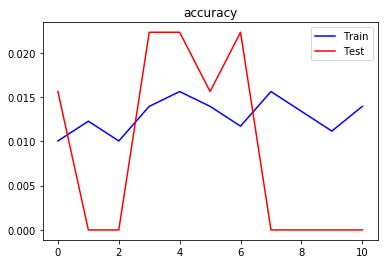

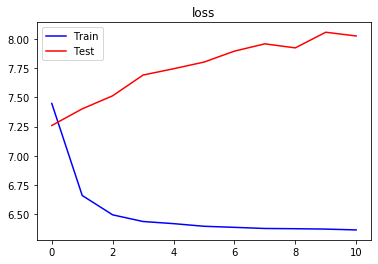

In [35]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
acc_v = history.history['val_accuracy']
loss = history.history['loss']
loss_v = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Train')
plt.plot(epochs, acc_v, 'r', label='Test')
plt.legend()
plt.title('accuracy')

plt.figure()

plt.plot(epochs, loss, 'b', label='Train')
plt.plot(epochs, loss_v, 'r', label='Test')
plt.title('loss')
plt.legend()

plt.show()

In [42]:
# seed_text = "Мама мыла раму"
seed_text = "Непослушный ребенок пошел гулять"
next_words = 10
  
for _ in range(next_words):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    print(token_list)
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
    predicted = model.predict_classes(token_list, verbose=0)
#     y_p=model.predict(token_list)
    output_word = ""
    y_p=model.predict(token_list)
    for word, index in tokenizer.word_index.items():
        if index == predicted:
            output_word = word
            break
    seed_text += " " + output_word
print(seed_text)

[221]
[221, 3]
[221, 3, 3]
[221, 3, 3, 3]
[221, 3, 3, 3, 3]
[221, 3, 3, 3, 3, 3]
[221, 3, 3, 3, 3, 3, 3]
[221, 3, 3, 3, 3, 3, 3, 3]
[221, 3, 3, 3, 3, 3, 3, 3, 3]
[221, 3, 3, 3, 3, 3, 3, 3, 3, 3]
Непослушный ребенок пошел гулять девочка девочка девочка девочка девочка девочка девочка девочка девочка девочка
